In [25]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="LangSmith now uses UUID v7", 
    category=UserWarning,
)

In [28]:
from datetime import datetime
import os

from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent

from deepagents.middleware.skills import SkillsMiddleware
from deepagents.backends.state import StateBackend

# === Инструменты (tools) ===
from src.file_tools import ls, read_file, write_file
from src.todo_tools import write_todos, read_todos
from src.research_tools import tavily_search, think_tool, get_today_str
from src.tools import get_current_datetime, constitution_search
from src.prompts import RESEARCHER_INSTRUCTIONS
# === Состояние ===
from src.state import DeepAgentState

# === Task tool для субагентов ===
from src.task_tool import _create_task_tool


# === Настройка LLM ===
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
if not OPENROUTER_API_KEY:
    raise EnvironmentError("Установите OPENROUTER_API_KEY в файле .env")

model = ChatOpenAI(
    model="google/gemini-3-flash-preview",
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
    temperature=0.0
)

# === Параметры ===
max_concurrent_research_units = 3
max_researcher_iterations = 3

# === Инструменты ===
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]
date_tools = [get_current_datetime, constitution_search]

# === Субагент-исследователь ===
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# === Создание task_tool для делегирования ===
task_tool = _create_task_tool(
    sub_agent_tools, 
    [research_sub_agent], 
    model, 
    DeepAgentState
)

# === Все инструменты ===
all_tools = built_in_tools + [task_tool] + date_tools

# === Skills Middleware ===
skills_middleware = SkillsMiddleware(
    backend=lambda rt: StateBackend(rt),
    sources=["/skills/base/"]
)

# === Создание агента БЕЗ system_prompt ===
agent = create_agent(
    model=model,
    tools=all_tools,
    state_schema=DeepAgentState,
    middleware=[skills_middleware]  # ← всё управление через skills
)

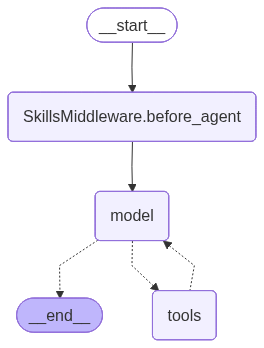

In [29]:
# === Визуализация графа ===
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
from utils import format_message
result = agent.invoke({
    "messages": [{"role": "user", "content": "Какие полномочия у президента РФ?"}]
})

format_message(result["messages"])

┌───────────────────────────────── 🧑 Human ──────────────────────────────────┐
│ Какие полномочия у президента РФ?                                           │
└─────────────────────────────────────────────────────────────────────────────┘
┌─────────────────────────────────── 📝 AI ───────────────────────────────────┐
│                                                                             │
│                                                                             │
│ 🔧 Tool Call: write_todos                                                   │
│    Args: {                                                                  │
│   "todos": [                                                                │
│     {                                                                       │
│       "content": "Изучить Конституцию РФ на предмет полномочий Президента", │
│       "status": "in_progress"                                               │
│     },                                   